In [36]:
# Imports for all the other steps

import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import random
import time
import warnings


from decimal import Decimal
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from Model import Date2VecConvert

warnings.simplefilter(action='ignore')

In [15]:
# Astra Connection Information

# this is the file with clientID, clientSecret and token you get when you create a new token in Astra
ASTRA_TOKEN_JSON_FILE = './dbName-token.json'

# this is the zip file Astra gives you once your DB is ready
ASTRA_SECURE_CONNECT_BUNDLE = './secure-connect-dbName.zip'

# a name for the keyspace we work in, can be (almost) anything you want
ASTRA_KEYSPACE_NAME = 'keyspaceName'

In [5]:
# load the data and prepare the df

df = pd.read_parquet('./data/electricity/train-00000-of-00001.parquet', engine='pyarrow')

data = df.sort_index(axis=0, ascending=True)

data["Date"] = pd.to_datetime(data["__index_level_0__"])
data.set_index('Date', inplace=True)
data = data.reset_index().rename(columns={'index': 'Date'})
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(columns=['__index_level_0__'], axis=1)

data

,Date,Demand,Temperature
0,2014-01-01 00:00:00,3.794,18.05
1,2014-01-01 01:00:00,3.418,17.20
2,2014-01-01 02:00:00,3.152,16.45
3,2014-01-01 03:00:00,3.026,16.65
4,2014-01-01 04:00:00,3.022,16.40
...,...,...,...
1339,2014-02-25 19:00:00,4.968,20.10
1340,2014-02-25 20:00:00,4.742,19.90
1341,2014-02-25 21:00:00,4.304,19.30
1342,2014-02-25 22:00:00,4.105,19.05


In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

data = train_data

len(df), len(train_data), len(test_data)

(1344, 1075, 269)

In [7]:
# Create sliding windows dataset

"""
As an example, we take 3-h windows
and then start the next widnows after 2 hours.

SLIDING_WINDOW_SIZE = 3
STEP = 2

        Date	            Demand	Temperature
0:3	0	2014-01-01 00:00:00	3.794	18.05
    1	2014-01-01 01:00:00	3.418	17.20
    2	2014-01-01 02:00:00	3.152	16.45

2:5	2	2014-01-01 02:00:00	3.152	16.45
    3	2014-01-01 03:00:00	3.026	16.65
"""

# For the real case, we take a 24h window
# Take the first 16h as the portion to embedd
# We do a step of every hour to get as many samples as possible
SLIDING_WINDOW_SIZE = 24
PORTION_TO_EMBED = 16
STEP = 1

def windows(data, window_size, step):
    r = np.arange(len(data))
    s = r[::step]
    z = list(zip(s, s + window_size))
    f = '{0[0]}:{0[1]}'.format
    g = lambda t: data.iloc[t[0]:t[1]]
    return pd.concat(map(g, z), keys=map(f, z))

wdf = windows(data, SLIDING_WINDOW_SIZE, STEP)
wdf

Date  Demand  Temperature
0:24      0    2014-01-01 00:00:00   3.794        18.05
          1    2014-01-01 01:00:00   3.418        17.20
          2    2014-01-01 02:00:00   3.152        16.45
          3    2014-01-01 03:00:00   3.026        16.65
          4    2014-01-01 04:00:00   3.022        16.40
...                            ...     ...          ...
1072:1096 1073 2014-02-14 17:00:00   5.557        26.35
          1074 2014-02-14 18:00:00   5.304        26.25
1073:1097 1073 2014-02-14 17:00:00   5.557        26.35
          1074 2014-02-14 18:00:00   5.304        26.25
1074:1098 1074 2014-02-14 18:00:00   5.304        26.25

[25524 rows x 3 columns]

In [37]:
# Load the Time2Vec model

d2v = Date2VecConvert(model_path="./d2v_model/d2v_98291_17.169918439404636.pth")

In [38]:
# Vectorize each time window (the first PORTION_TO_EMBED-long part of it)

def get_embedding_for_window(df):

    date_scaler = MinMaxScaler()
    demand_scaler = MinMaxScaler()
    temperature_scaler = MinMaxScaler()
    
    df[['date_n']] = date_scaler.fit_transform(df[['Date']].values.astype(np.int64))
    df[['demand_n']] = demand_scaler.fit_transform(df[['Demand']])
    df[['temperature_n']] = temperature_scaler.fit_transform(df[['Temperature']])

    # the Time2Vec model needs exactly 6-value long array as input
    # so we pad with 0s
    df['dummy1'] = 0
    df['dummy2'] = 0
    df['dummy3'] = 0    
    rows = df[['date_n', 'demand_n', 'temperature_n', 'dummy1', 'dummy2', 'dummy3']].values
    embedding = d2v(rows)

    flat_embeddings = [item.item() for sublist in embedding for item in sublist]

    return flat_embeddings

# Prepare sequences for upload 
items_to_upload = []
for window_i, window_df in wdf.groupby(level=0):
    if window_df.shape[0] == SLIDING_WINDOW_SIZE:
        half_window_df = window_df.head(PORTION_TO_EMBED)
        embedding = get_embedding_for_window(half_window_df)
        if embedding:
            items_to_upload.append((window_df, embedding))
    
len(items_to_upload)

1052

In [14]:
# check the size of the vectors we got
# we need to know this for schema creation in Astra

VECTOR_SIZE = len(items_to_upload[0][1])
VECTOR_SIZE

1024

In [25]:
# Connect to Astra and create the tables and indexes

with open(ASTRA_TOKEN_JSON_FILE, 'r') as tf:
    d = json.loads(tf.read())
    client_id = d['clientID']
    client_secret = d['clientSecret']

cloud_config= {
  'secure_connect_bundle': ASTRA_SECURE_CONNECT_BUNDLE
}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    # print(row[0])
    pass
else:
    print("An error occurred.")

drop_table = f"DROP TABLE IF EXISTS {ASTRA_KEYSPACE_NAME}.electricity"
session.execute(drop_table)

create_table = f"""
CREATE TABLE IF NOT EXISTS {ASTRA_KEYSPACE_NAME}.electricity (
  id text PRIMARY KEY,
  orig_timestamps vector<float, {SLIDING_WINDOW_SIZE}>,
  orig_demand VECTOR<float, {SLIDING_WINDOW_SIZE}>,
  orig_temperature VECTOR<float, {SLIDING_WINDOW_SIZE}>,
  embedding VECTOR<float, {VECTOR_SIZE}>,  
);
"""
session.execute(create_table)

create_index = f"""
CREATE CUSTOM INDEX IF NOT EXISTS demand_embedding_index 
  ON {ASTRA_KEYSPACE_NAME}.electricity(embedding) 
  USING 'StorageAttachedIndex'
  WITH OPTIONS = {{ 'similarity_function': 'dot_product' }}
  ;
"""
_ = session.execute(create_index)

# no output if all goes well

In [26]:
# Upload the time windows and their embeddings

# hide warn messages
logging.getLogger('cassandra').setLevel(logging.ERROR)

prepared_insert = session.prepare(f"""
    INSERT INTO kats.electricity 
    (id, orig_timestamps, orig_demand, orig_temperature, embedding) 
    VALUES (?, ?, ?, ?, ?)
    """)

print(f"Uploading {len(items_to_upload)} items.")

for window_df, embeddings in items_to_upload:
    row_id = window_df.index[0][0] # 0:64 ~ identifier of the indices of the values
    timestamps = window_df['Date'].values.tolist()
    demands = window_df['Demand'].values.tolist()
    temperatures = window_df['Temperature'].values.tolist()
    embeddings = embeddings
    # wrapping in a loop to do naiive retries
    while True:
        try:
            session.execute(prepared_insert, (row_id, timestamps, demands, temperatures, embeddings))
            break
        except Exception as e:
            # this sometimes happens when the size of the windows is not aligned
            print(f'id was: {row_id} :: Vector sizes: {len(timestamps)} {len(demands)} {len(temperatures)} {len(embeddings)}')
            break

Uploading 1052 items.


Picking sequence starting at index 65


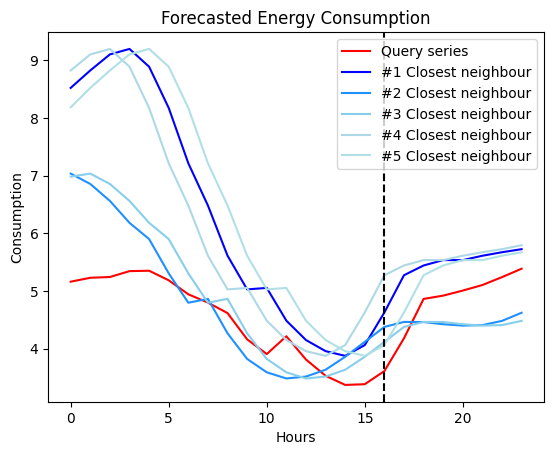

In [28]:
# An example query for similar vectors


# select a random sequence from the TEST data set
random_point = random.randint(0, len(test_data)-SLIDING_WINDOW_SIZE)

print(f"Picking sequence starting at index {random_point}")

# get the query time window
q_df = test_data.iloc[random_point:random_point+SLIDING_WINDOW_SIZE, :]
# take the first part of it to embedd
q_wdf = q_df.head(PORTION_TO_EMBED)

# embed the selected sequence
embedding = get_embedding_for_window(q_wdf)

# do a nearest-neighbours query on the embedding
q = f"""
SELECT * FROM kats.electricity
ORDER BY embedding ANN OF {embedding} LIMIT 5
"""
rows = session.execute(q)

# make simple lists of
# original demands we got from the neighbours
orig_demands = [row.orig_demand for row in rows]
# the input demand we queried with
query_demand = q_df[['Demand']].values.tolist()

# helper function to plot the lines
def plot_arrays(arrays, vertical_line_x, colors, labels):
    fig, ax = plt.subplots()
    for i, array in enumerate(arrays):
        ax.plot(array, color=colors[i], label=labels[i])
    ax.axvline(x=vertical_line_x, color='black', linestyle='--')  # Add vertical line
    ax.set_title(f'Forecasted Energy Consumption')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Consumption')
    ax.legend()
    plt.show()

# concatenate the arrays for plotting purposes
arrays = [query_demand] + orig_demands

# Define x coordinate for the vertical line to show which part was used for embedding
vertical_line_x = PORTION_TO_EMBED

# Define colors for the arrays, first one in red and others in fading-out shades of blue
colors = ['red', 'blue', 'dodgerblue', 'skyblue', 'lightblue', 'powderblue']
labels = [
    'Query series',
    '#1 Closest neighbour',
    '#2 Closest neighbour',
    '#3 Closest neighbour',
    '#4 Closest neighbour',
    '#5 Closest neighbour',
]

# plot the array
plot_arrays(arrays, vertical_line_x, colors, labels)